In [ ]:
#@title
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120

import numpy as np
import pandas as pd
from math import ceil
from scipy import linalg
from scipy.interpolate import interp1d

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
from sklearn.model_selection import train_test_split as tts, KFold
from sklearn.metrics import mean_squared_error as mse
import statsmodels.api as sm
from math import ceil
from IPython.display import Image
from IPython.display import display
plt.style.use('seaborn-white')

# the following line(s) are necessary if you want to make SKlearn compliant functions
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

# Project 1


## What is Regression?

Regression is a technique of predicting an output, or dependent variable, given one or more inputs, or independent variables.

Mathematically, let $X$ be the inputs and $y$ be the outputs. Then, the regression equation can be shown as $$\mathbb{E}(y|X) = f(X).$$

Taking the expectation of the outputs demonstrates a minimization of the **mean squared error (MSE)**: the squared difference between the data points and the estimator function. By minimizing this, we can reasonably be sure that we have a good estimator function, based on the data we have.

***Linear* regression** specifies the use of a straight line for the regression, rather than a curve.


So, let $X=\{x_1,x_2,...,x_n\}$ be the inputs, $ B =\{\beta_1,\beta_2,...,\beta_n\}$ be the coefficients, and $y$ be the outputs.  Then the linear regression model is $$y=X \cdot B=x_1 \cdot \beta_1 + x_2 \cdot \beta_2 + ... + x_n \cdot \beta_n.$$

The only problem with this equation is the noise.  It is rare that the inputs and outputs are perfectly correlated, so it is safe to assume there is some noise variable for each point, randomly distributed on the Gaussian curve, leaving us with the equation $$y=X \cdot B + \sigma \epsilon$$

To solve for the coefficients, there are several matrix manipulations we must make to preserve the shape of the input features.  

First, we multiply by the transpose of $X$ to make $X^TX$ a square, then  multiply by the inverse of $X^TX$ (assuming $X^TX$ is invertible).  

$$\begin{align} X^Ty &= X^TX \cdot B + \sigma X^T \epsilon \\
(X^TX)^{-1}(X^Ty) &= (X^TX)^{-1}(X^TX) \cdot B + \sigma (X^TX)^{-1}(X^T \epsilon) \end{align}$$

Since a matrix times its own inverse is equal to the identity matrix, we then solve for the coefficient vector, $B$.  

$$\begin{align} 
(X^TX)^{-1}(X^Ty) &= B + \sigma (X^TX)^{-1}(X^T \epsilon) \\
B &= (X^TX)^{-1}(X^Ty) - \sigma (X^TX)^{-1}(X^T \epsilon) \\
\end{align}$$

The expectation (mean) of the noise variable is zero, so taking the expectation of the coefficients (evaluating MSE) eliminates the noise variable, leaving us with the expected value of the coefficients.

$$\bar{B} = (X^TX)^{-1}(X^Ty)$$

If we insert these estimated coefficients back into the equation, we get our predicted outputs:

$$\hat{y} = X \cdot (X^TX)^{-1}(X^Ty)$$

The last important piece of this puzzle, is the weights.  Certain features are going to correlate more with the output and the weights are how correlated features are emphasized and uncorrelated or less-correlated features are deemphasized in the estimation process.  The weights ($W$) are associated with the inputs, so our final equation looks like this:

$$\hat{y} = X \cdot (X^TWX)^{-1}(X^TWy)$$

## Locally Weighted Regression

Locally weighted regression is a method of executing linear regression on data with nonlinear trends and/or associations.  However, rather than using the whole data set for the regression, locally weighted regression evaluates the regression at multiple points of interest, with the weights based on the data points' distance from the point of interest.

For example, in the image below, the point of interest is the vertical line, and since the points nearest the point of interest have a negative linear trend, the line of regression has a negative slope.  The points farther away from the point of interest demonstrate a nonlinear trend, but since they are farther away, their weights are smaller (if not zero) and have little to no influence on the line of regression.

![LWR_ex.png](https://miro.medium.com/max/1400/1*H3QS05Q1GJtY-tiBL00iug.webp)

### Kernels

Locally weighted regression typically relies on a specified kernel to calculate the weights.  Some common ones are Gaussian, Tricubic, Epanechnikov, and Quartic.  These kernels determine the shape of the curve that calculates the weights, placing more or less significance on the surrounding points depending on the kernel.

Here are some examples of those kernels:

In [ ]:
# Define each kernel's function
def Gaussian(x):
  return np.where(np.abs(x)>4,0,1/(np.sqrt(2*np.pi))*np.exp(-1/2*x**2))

def Tricubic(x):
  return np.where(np.abs(x)>1,0,70/81*(1-np.abs(x)**3)**3)

def Epanechnikov(x):
  return np.where(np.abs(x)>1,0,3/4*(1-np.abs(x)**2))

def Quartic(x):
  return np.where(np.abs(x)>1,0,15/16*(1-np.abs(x)**2)**2) 

In [ ]:
# Define outputs for each kernel
x = np.linspace(-1,1,201)
y_gaussian = Gaussian(x)
y_tricubic = Tricubic(x)
y_epanechnikov = Epanechnikov(x)
y_quartic = Quartic(x)

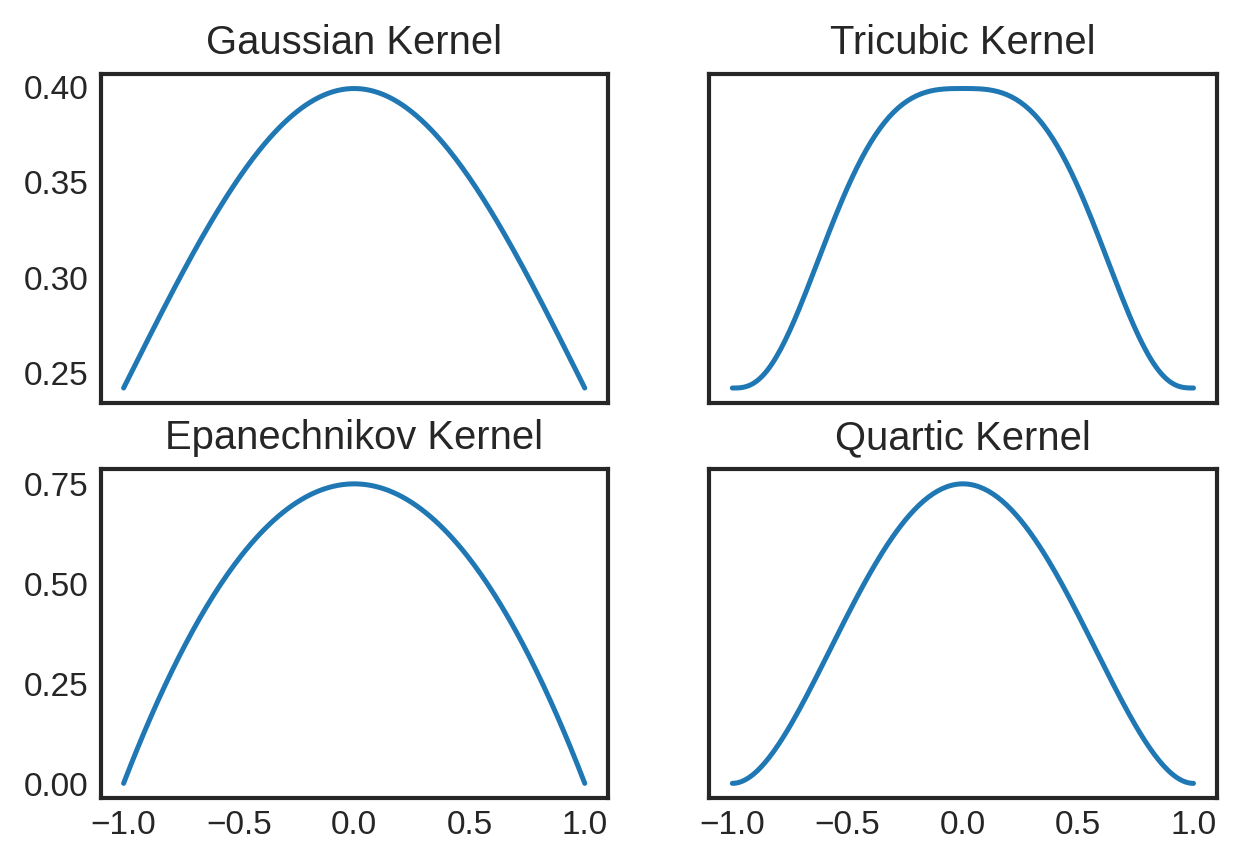

In [ ]:
# Plot each kernel
fig, axs = plt.subplots(2,2)

axs[0,0].set_title('Gaussian Kernel')
axs[0,0].plot(x, y_gaussian)
axs[0,1].set_title('Tricubic Kernel')
axs[0,1].plot(x, y_tricubic)
axs[1,0].set_title('Epanechnikov Kernel')
axs[1,0].plot(x, y_epanechnikov)
axs[1,1].set_title('Quartic Kernel')
axs[1,1].plot(x, y_quartic)

for ax in axs.flat:
    ax.label_outer()

plt.show()

## A Real Life Example